In [1]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})
plt.rc('font', family='arial')

In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-labs/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

In [3]:
GC_WINDOW_SIZE = 1000

## Non-exonic non-enhancer Chen windows, with Gnocchi, and various features (e.g. GC content)

In [4]:
import polars as pl

def get_unconstrained_noncoding_windows(): 
    df = pl.read_csv(
        # non-exonic windows
        f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.features.constraint_scores.bed', 
        separator='\t',
    )
    df = df.filter(pl.col('window overlaps enhancer') == False) # putatively unconstrained windows 
    df = df.to_pandas()
    return df 
    
UNCONSTRAINED_NONCODING_WINDOWS = get_unconstrained_noncoding_windows()
UNCONSTRAINED_NONCODING_WINDOWS

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi,depletion_rank_constraint_score,depletion_rank_constraint_score_complement
0,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657,0.679834,0.320166
1,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925,0.320987,0.679013
2,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243,0.718503,0.281497
3,chr1,1467000,1468000,2.958469,273,False,False,0.651,0.039046,0.025852,...,2.585568,0.636364,0.552345,0.583014,0.574087,NaN,False,326.453703,0.805056,0.194944
4,chr1,1476000,1477000,-0.662737,301,False,False,0.651,0.039046,0.025852,...,2.585568,0.556444,0.595440,0.582994,0.573887,NaN,False,289.719448,0.883274,0.116726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693265,chr9,137136000,137137000,3.277688,258,False,False,0.555,0.150095,0.005393,...,2.281162,0.631369,0.551045,0.588594,0.583316,NaN,False,316.292417,0.558267,0.441733
693266,chr9,137137000,137138000,2.779895,254,False,False,0.555,14.102295,1.698819,...,2.281162,0.586414,0.559444,0.587014,0.583278,NaN,False,302.336307,0.422128,0.577872
693267,chr9,137138000,137139000,3.286597,219,False,False,0.556,0.150095,0.005393,...,2.281162,0.616384,0.584242,0.588514,0.583253,217.0,True,273.337005,0.002164,0.997836
693268,chr9,137146000,137147000,6.685589,237,False,False,0.556,0.004152,0.000249,...,2.281162,0.666334,0.620738,0.600204,0.582346,116.0,True,364.670293,0.545990,0.454010


## Logistic regression: predicting Gnocchi in putatively unconstrained noncoding windows as a function of GC_content, gBGC and BGS 

In [15]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd

def f(df, features=['B', f'GC_content_{GC_WINDOW_SIZE}bp', 'B_M1star.EUR'], target='gnocchi'):
    X = df[features]

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    standardized_features = [f'standardized_{feature}' for feature in features]
    X = pd.DataFrame(X, columns=standardized_features)

    X = sm.add_constant(X)

    y = df[target]

    model = sm.OLS(y, X)
    results = model.fit()

    y_pred = results.predict(X)
    df['predicted_gnocchi'] = y_pred
    
    print(f'proportion of variance in gnocchi explained by {standardized_features}: {results.rsquared}')

    coefficients = results.params
    standard_errors = results.bse
    pvalues = results.pvalues

    for standardized_feature in standardized_features:
        print(f'{standardized_feature}:')
        print(f'  Coefficient: {coefficients[standardized_feature]:.3g}')
        print(f'  Standard Error: {standard_errors[standardized_feature]:.3g}')
        print(f'  P-value: {pvalues[standardized_feature]:.3g}')


f(UNCONSTRAINED_NONCODING_WINDOWS)

proportion of variance in gnocchi explained by ['standardized_B', 'standardized_GC_content_1000bp', 'standardized_B_M1star.EUR']: 0.07644844059149958
standardized_B:
  Coefficient: -0.078
  Standard Error: 0.00225
  P-value: 8.43e-264
standardized_GC_content_1000bp:
  Coefficient: 0.501
  Standard Error: 0.00224
  P-value: 0
standardized_B_M1star.EUR:
  Coefficient: 0.127
  Standard Error: 0.00226
  P-value: 0


In [6]:
# TODO 
# 1. call "f" using just GC content and show that R2 is approximately the same 
# 2. incorporate the plots below into "f"
# 3. repeat for DR, CDTS and lamba_s

In [7]:
# Import necessary library
import matplotlib.pyplot as plt


# Create a hexbin plot of actual vs. predicted values
plt.hexbin(y, y_pred, gridsize=50, cmap='Blues')
cb = plt.colorbar(label='count in bin')

# Superimpose a diagonal line
limits = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
plt.plot(limits, limits, 'k-', color = 'r')

# Set x and y limits
plt.xlim([-2, 2])
plt.ylim([-2, 2])

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Hexbin of Actual vs. Predicted')
plt.show()

NameError: name 'results' is not defined

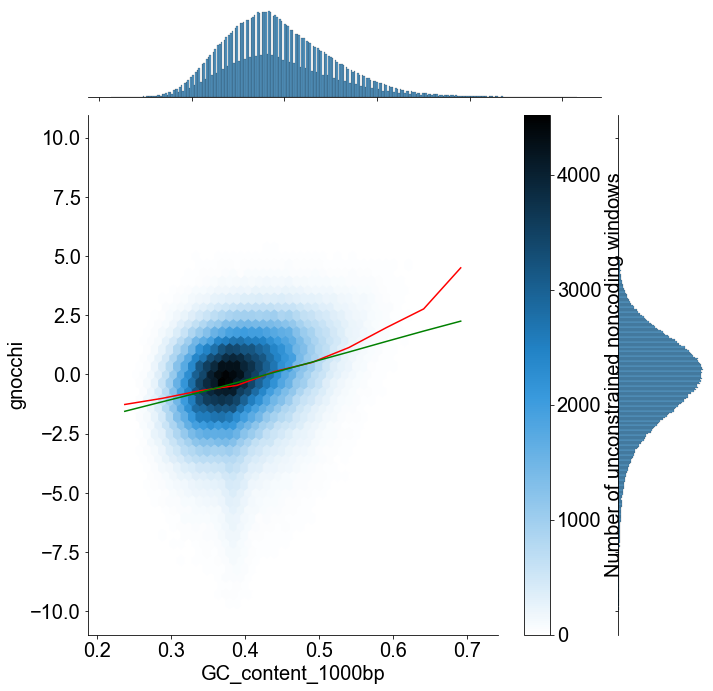

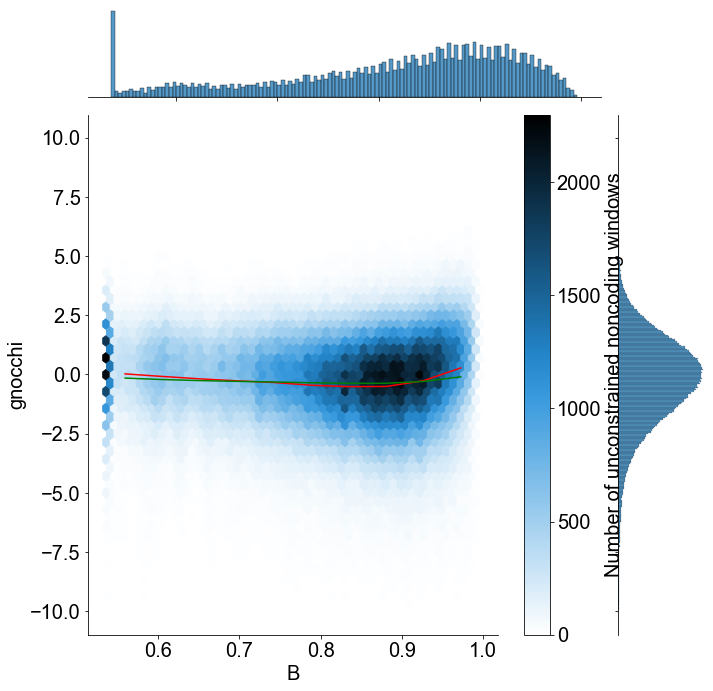

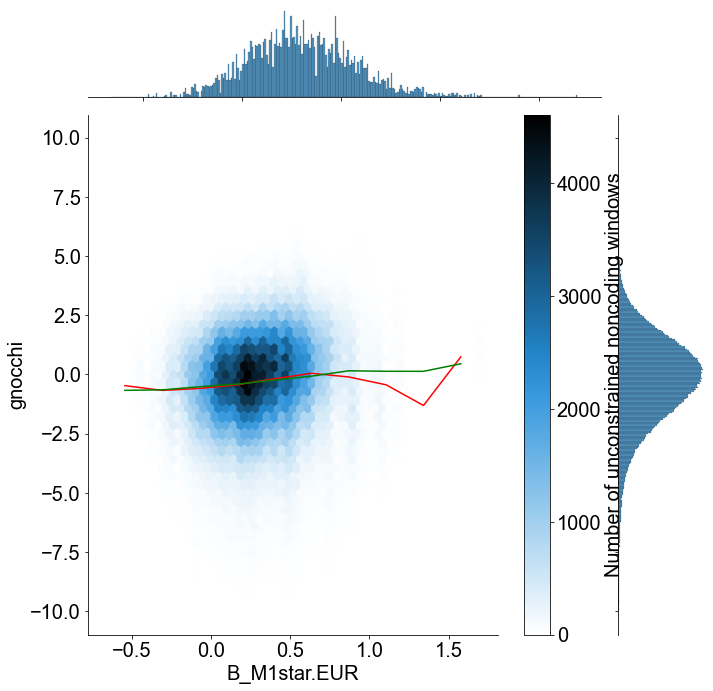

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heat_map(df, feature):
    # Create a hex bin plot
    heatmap = sns.jointplot(data=df, x=feature, y='gnocchi', kind='hex', height=10)

    # Add a colorbar and label it
    cbar = plt.colorbar(heatmap.ax_joint.collections[0], ax=heatmap.ax_joint)
    cbar.set_label('Number of unconstrained noncoding windows')

    # Bin by GC content
    df[f'{feature}_bin_midpoints'] = (pd
        .cut(df[feature], bins=10, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )

    # Calculate the average gnocchi value in each bin
    average_gnocchi = df.groupby(f'{feature}_bin_midpoints')['gnocchi'].mean()
    average_predicted_gnocchi = df.groupby(f'{feature}_bin_midpoints')['predicted_gnocchi'].mean()

    # Superimpose the average gnocchi value on the hex bin plot
    plt.plot(average_gnocchi.index, average_gnocchi.values, color='red')
    plt.plot(average_predicted_gnocchi.index, average_predicted_gnocchi.values, color='green')

    plt.show()

plot_heat_map(UNCONSTRAINED_NONCODING_WINDOWS, f'GC_content_{GC_WINDOW_SIZE}bp')
plot_heat_map(UNCONSTRAINED_NONCODING_WINDOWS, 'B')
plot_heat_map(UNCONSTRAINED_NONCODING_WINDOWS, 'B_M1star.EUR')